In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Load the train and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
# Split the target variable from the train data
train_target = np.log1p(train_data["SalePrice"])
train_data.drop("SalePrice", axis=1, inplace=True)

In [4]:
# Concatenate the train and test data
data = pd.concat([train_data, test_data], ignore_index=True)

In [5]:
# Handle the missing values
data.fillna(data.mean(), inplace=True)

C:\Users\hamud\AppData\Local\Temp\ipykernel_14332\2446735020.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


In [6]:
# Create the numerical and categorical features
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
categorical_features = data.select_dtypes(exclude=np.number).columns.tolist()

In [7]:
# Preprocess the numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [8]:
# Preprocess the categorical features
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(data[categorical_features])
encoded_cols = encoder.get_feature_names_out(input_features=categorical_features)
encoded_data = pd.DataFrame(encoded_data.toarray(), columns=encoded_cols)
data = pd.concat([data, encoded_data], axis=1)
data.drop(categorical_features, axis=1, inplace=True)

In [9]:
# Split the preprocessed data into train and test sets
train_data = data[:len(train_target)]
test_data = data[len(train_target):]

In [10]:
# Split the data into train and validation sets
train_data, val_data, train_target, val_target = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

In [11]:
# Train the model using GridSearchCV
params = {'n_estimators': [500],
          'max_depth': [10,15,20]}
grid_search = GridSearchCV(RandomForestRegressor(), params, cv=10)
grid_search.fit(train_data, train_target)
model = grid_search.best_estimator_

RandomForestRegressor(max_depth=30)

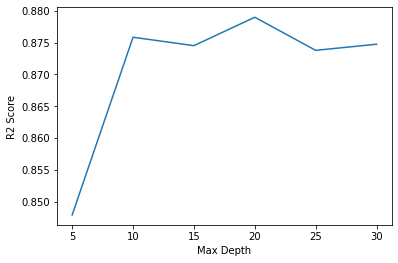

In [12]:
import matplotlib.pyplot as plt

max_depths = [5, 10, 15, 20, 25, 30]
r2_scores = []

for depth in max_depths:
    model = RandomForestRegressor(max_depth=depth)
    model.fit(train_data, train_target)
    val_pred = model.predict(val_data)
    r2_scores.append(r2_score(val_target, val_pred))

plt.plot(max_depths, r2_scores)
plt.xlabel("Max Depth")
plt.ylabel("R2 Score")
plt.show()


In [13]:
results = grid_search.cv_results_
n_estimators = [100, 200, 500]
mean_test_scores = results["mean_test_score"]
std_test_scores = results["std_test_score"]

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

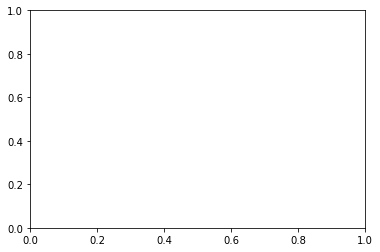

In [16]:
# # Extract the mean test scores from the grid search results
# n_estimators = params['n_estimators']
# mean_test_scores = grid_search.cv_results_['mean_test_score']

# # Plot the mean test scores as a function of n_estimators
# plt.plot(n_estimators, mean_test_scores)
# plt.xlabel('n_estimators')
# plt.ylabel('Mean Test Score')
# plt.title('Grid Search Results')
# plt.show()


In [17]:
# Predict on the validation set
val_pred = model.predict(val_data)

In [18]:
# Evaluate the model
val_rmse = np.sqrt(mean_squared_error(val_target, val_pred))
val_r2 = r2_score(val_target, val_pred)
val_mae = mean_absolute_error(val_target, val_pred)
print("Validation RMSE:", val_rmse)
print("Validation R2:", val_r2)
print("Validation MAE:", val_mae)

Validation RMSE: 0.13770525942509768
Validation R2: 0.8747491374413565
Validation MAE: 0.09133967983202528


In [19]:
# Predict on the test set
test_pred = model.predict(test_data)

In [20]:
#Print CSV
output = pd.DataFrame({"Id": test_data.index + 1, "SalePrice": test_pred})
output.to_csv("submission#5less_depth.csv", index=False)